In [1]:
!pip install gymnasium==1.1.1

![Alt Text](img_8.png)

The algorithm generates a trace using the collect episodes function
Learning rate = alpha =0.002

Policy(pi) = {s0, a0, r0, .... st}

Since the pytorch loss function is minimization based, the original algorithm sets the loss term as -ve based.

Rewards are summed as
Rewards = sum (discount_factor * rewards)

What is log_probs?
Log Probabilities of the action taken log phi(at|st)

The policy loss is computed as
policy_loss = log_probs * discounted_rewards

Calculating the gradient of the function is as simple as

optimizer.zero_grad()
policy_loss.backward()
optimizer.step()



Using device: cuda
Episode 10	Avg Reward: 35.3	100-ep Avg: 28.6	Loss: -5.10
Episode 20	Avg Reward: 25.8	100-ep Avg: 30.6	Loss: -3.24
Episode 30	Avg Reward: 40.9	100-ep Avg: 33.0	Loss: -1.71
Episode 40	Avg Reward: 46.1	100-ep Avg: 34.6	Loss: -0.56
Episode 50	Avg Reward: 45.8	100-ep Avg: 36.6	Loss: -0.93
Episode 60	Avg Reward: 40.9	100-ep Avg: 38.0	Loss: 4.42
Episode 70	Avg Reward: 49.5	100-ep Avg: 39.6	Loss: 2.30
Episode 80	Avg Reward: 42.2	100-ep Avg: 40.0	Loss: 3.77
Episode 90	Avg Reward: 46.9	100-ep Avg: 41.5	Loss: 2.03
Episode 100	Avg Reward: 26.4	100-ep Avg: 40.6	Loss: -2.96
Episode 110	Avg Reward: 52.6	100-ep Avg: 41.7	Loss: 5.38
Episode 120	Avg Reward: 65.0	100-ep Avg: 44.3	Loss: 3.23
Episode 130	Avg Reward: 76.2	100-ep Avg: 47.4	Loss: -3.99
Episode 140	Avg Reward: 76.1	100-ep Avg: 49.1	Loss: -1.55
Episode 150	Avg Reward: 73.1	100-ep Avg: 51.0	Loss: -0.17
Episode 160	Avg Reward: 56.2	100-ep Avg: 52.7	Loss: -3.52
Episode 170	Avg Reward: 88.9	100-ep Avg: 54.9	Loss: 2.74
Episode 180

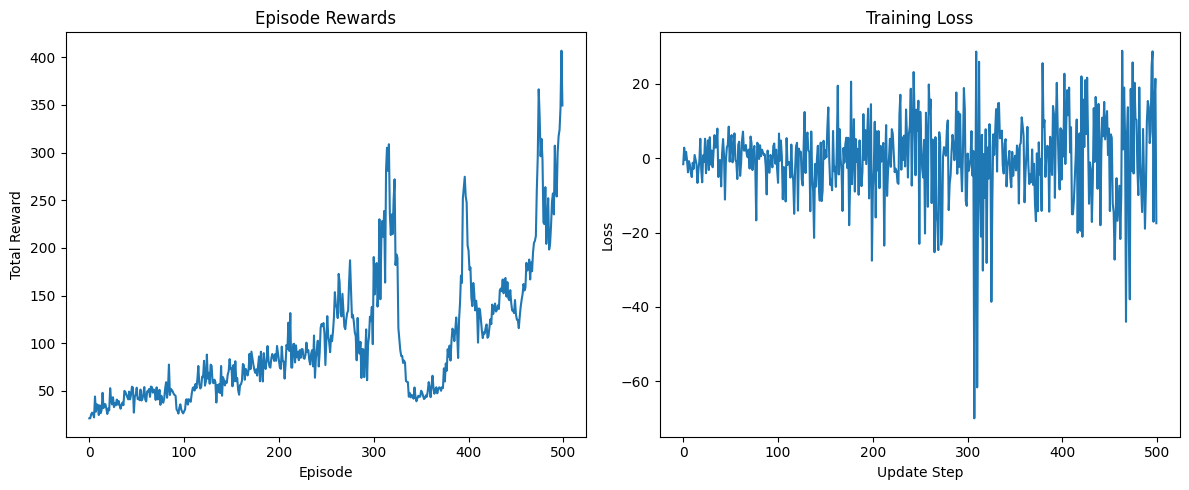

In [2]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from collections import deque

# Hyperparameters
learning_rate = 0.002
gamma = 0.99
episodes = 500
hidden_size = 256
max_steps = 1000
batch_size = 10  # Number of episodes before update
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Environment setup (rendering disabled for faster training)
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.dropout = nn.Dropout(0.3)
        self.to(device)  # Move model to GPU

        # Training statistics
        self.reward_history = []
        self.loss_history = []
        self.episode_lengths = []

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x).to(device)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

policy = Policy()
optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)

def collect_episodes(n_episodes=1):
    states, actions, rewards, log_probs = [], [], [], []
    episode_rewards = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for t in range(max_steps):
            # Get action probabilities and sample action
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs = policy(state_tensor)
            dist = Categorical(action_probs)
            action = dist.sample()

            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            # Store transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(dist.log_prob(action))

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)

    return states, actions, rewards, log_probs, episode_rewards

def update_policy(states, actions, rewards, log_probs):
    # Convert to tensors and move to GPU
    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.stack(actions).to(device)
    log_probs = torch.stack(log_probs).to(device)
    rewards = np.array(rewards)

    # Calculate discounted rewards
    discounted_rewards = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)

    # Normalize rewards
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / \
                       (discounted_rewards.std() + 1e-8)

    # Calculate loss
    policy_loss = (-log_probs * discounted_rewards).sum()

    # Update policy
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    return policy_loss.item()

def main():
    recent_rewards = deque(maxlen=100)

    for episode in range(1, episodes + 1):
        # Collect episodes
        states, actions, rewards, log_probs, episode_rewards = collect_episodes(batch_size)

        # Update policy
        loss = update_policy(states, actions, rewards, log_probs)

        # Update statistics
        avg_reward = np.mean(episode_rewards)
        recent_rewards.append(avg_reward)
        policy.reward_history.append(avg_reward)
        policy.loss_history.append(loss)
        policy.episode_lengths.append(len(rewards) / batch_size)

        # Print progress
        if episode % 10 == 0:
            avg_100 = np.mean(recent_rewards) if len(recent_rewards) >= 100 else np.mean(policy.reward_history)
            print(f"Episode {episode}\tAvg Reward: {avg_reward:.1f}\t100-ep Avg: {avg_100:.1f}\tLoss: {loss:.2f}")

            if avg_100 >= 195:
                print(f"Solved at episode {episode}!")
                break

    env.close()
    return policy

# Run training
trained_policy = main()

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trained_policy.reward_history)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(trained_policy.loss_history)
plt.title('Training Loss')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()